<a href="https://colab.research.google.com/github/desnug/project-thesis/blob/main/alarm_classification_CNN_final_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Alarm Classification For Deaf and Hard Hearing

Project Thesis by : Devis Styo Nugroho

## Setup

Import necessary modules and dependencies. and install some packages that we needed

In [1]:
!pip install tflite-runtime

     |████████████████████████████████| 2.2 MB 25.4 MB/s 


In [2]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 31.5 MB/s 


In [3]:
import numpy as np
import os
import requests
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("drive/MyDrive/data/dataset-alarm-folder")

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/data/dataset-alarm-folder"

In [6]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
!ls

alarm-dataset.zip  model-architecture.png  saved_model.sav
dataset		   model_audio.tflite	   testing
kaggle.json	   saved_model.h5	   testing.zip


In [8]:
#!kaggle datasets download -d devisdesnug/alarm-dataset

401 - Unauthorized


In [9]:
#!unzip alarm-dataset.zip

Archive:  alarm-dataset.zip
replace dataset/alarm_danger/1_danger_alarm_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Import Alarm Dataset

alarm dataset contain 3000 file data in 1 second, Sample Rate 16Khz, 

In [10]:
DATASET_PATH = 'dataset'

data_dir = pathlib.Path(DATASET_PATH)


The dataset's audio clips are stored in five folders corresponding to each *audio alarm: 'alarm_danger',  'alarm_fire',  'alarm_gas',  'non_alarm' and 'alarm_tsunami'* :

In [11]:
alarm = np.array(tf.io.gfile.listdir(str(data_dir)))
alarm = alarm[alarm != 'README.md']
print('alarm:', alarm)

alarm: ['alarm_danger' 'alarm_fire' 'alarm_gas' 'alarm_tsunami' 'non_alarm']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [12]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/alarm[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 3000
Number of examples per label: 600
Example file tensor: tf.Tensor(b'dataset/alarm_tsunami/5_tsunami_alarm_425.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [13]:
train_files = filenames[:2400]
val_files = filenames[2400: 2400 + 300]
test_files = filenames[-300:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 2400
Validation set size 300
Test set size 300


## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The  dataset only contains mono recordings. 

In [14]:
test_file = tf.io.read_file(DATASET_PATH+'/alarm_danger/1_danger_alarm_101.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [15]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [16]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [17]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

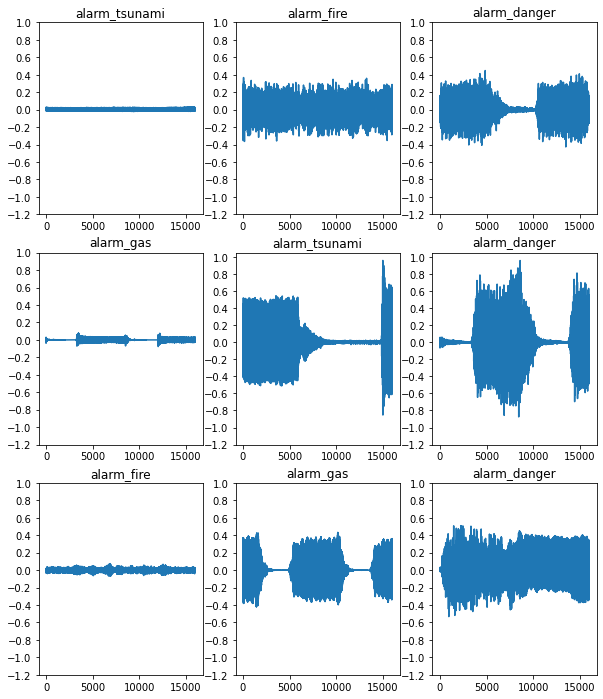

In [19]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [20]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [21]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: alarm_tsunami
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [22]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

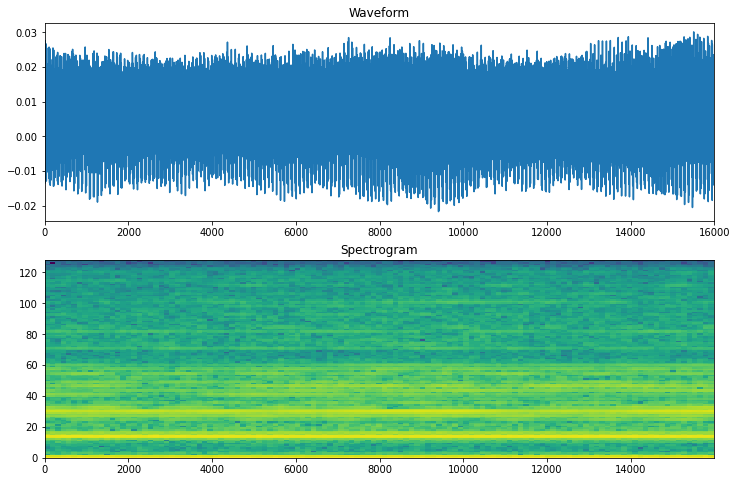

In [23]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

menentukan fungsi yang mengubah kumpulan data bentuk gelombang menjadi spektogram dan label yang sesuai sebagai ID integer (bilangan bulat:)

In [24]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == alarm)
  return spectrogram, label_id

memetakan `get_spectogram_and_label_id` di seluruh elemen set data dengan `Dataset.map`:

In [25]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

*memeriksa* contoh spektogram yang berbeda dari kumpulan data:

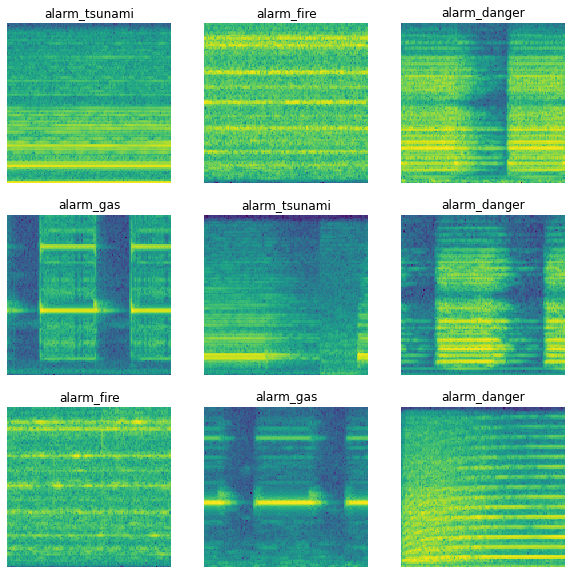

In [26]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(alarm[label_id.numpy()])
  ax.axis('off')

plt.show()

## Build and train the model

prapemrosesan set pelatihan pada set validasi dan pengujian:

In [27]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [28]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [29]:
val_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Batch the training and validation sets for model training:

In [30]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [31]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, I am using convolutional neural network (CNN), since I have transformed the audio files into spectrogram images.

my `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [32]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(alarm)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


Train the model over 10 epochs for demonstration purposes:

In [34]:
from datetime import datetime 
start = datetime.now()

EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS, verbose=1,
    
)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
38/38 [==============================] - 38s 977ms/step - loss: 0.6774 - accuracy: 0.7671 - val_loss: 0.2561 - val_accuracy: 0.9267
Epoch 2/50
38/38 [==============================] - 8s 209ms/step - loss: 0.2238 - accuracy: 0.9375 - val_loss: 0.1501 - val_accuracy: 0.9433
Epoch 3/50
38/38 [==============================] - 8s 211ms/step - loss: 0.1329 - accuracy: 0.9604 - val_loss: 0.1139 - val_accuracy: 0.9633
Epoch 4/50
38/38 [==============================] - 8s 211ms/step - loss: 0.0912 - accuracy: 0.9767 - val_loss: 0.1004 - val_accuracy: 0.9733
Epoch 5/50
38/38 [==============================] - 8s 209ms/step - loss: 0.0869 - accuracy: 0.9729 - val_loss: 0.0832 - val_accuracy: 0.9733
Epoch 6/50
38/38 [==============================] - 8s 209ms/step - loss: 0.0545 - accuracy: 0.9833 - val_loss: 0.0844 - val_accuracy: 0.9700
Epoch 7/50
38/38 [==============================] - 8s 209ms/step - loss: 0.0493 - accuracy: 0.9850 - val_loss: 0.0740 - val_accuracy: 0.9767
Epoch

Let's plot the training and validation loss curves to check how your model has improved during training:

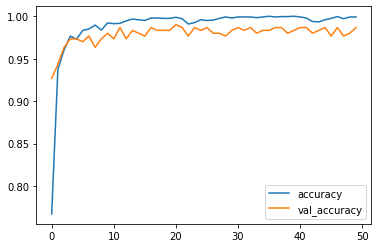

In [35]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

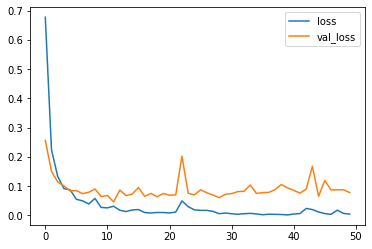

In [36]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [63]:
# Evaluating the model on the training and testing set
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
print("Train loss: {0:.3f}, train accuracy: {1:.3f}".format(train_loss, train_acc))

# Evaluating the model on the validation and testing set
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print("Val loss: {0:.3f}, val accuracy: {1:.3f}".format(val_loss, val_acc))


Train loss: 0.001, train accuracy: 1.000
Val loss: 0.078, val accuracy: 0.987


## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [38]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [39]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 98%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the alarm in the test set:


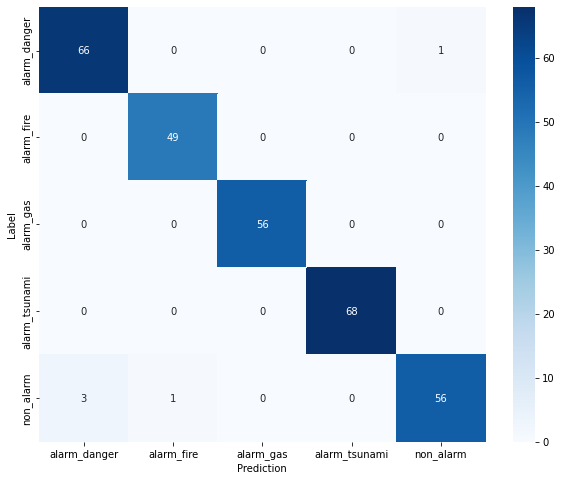

In [54]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=alarm,
            yticklabels=alarm,
            annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [41]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.957     0.985     0.971        67
           1      0.980     1.000     0.990        49
           2      1.000     1.000     1.000        56
           3      1.000     1.000     1.000        68
           4      0.982     0.933     0.957        60

    accuracy                          0.983       300
   macro avg      0.984     0.984     0.984       300
weighted avg      0.984     0.983     0.983       300



## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

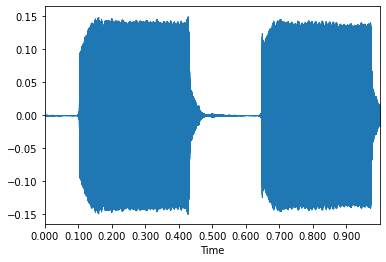

In [42]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

file_name='/content/drive/MyDrive/data/dataset-alarm-folder/testing/gas_alarm.gas_alarm_11.wav.2vgnslb7.ingestion-59654888d4-p85pp.wav'


audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveplot(audio_data,sr=sampling_rate)
ipd.Audio(file_name)

In [43]:
TESTING_DIR = 'testing'
test_dir = pathlib.Path(TESTING_DIR)

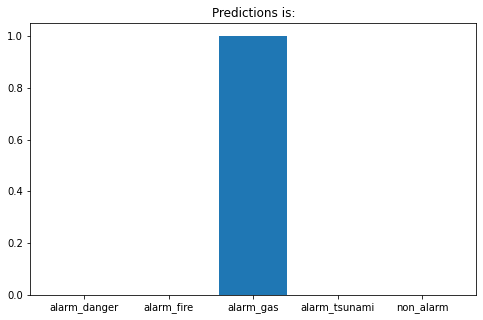

In [44]:
sample_file = file_name
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.figure(figsize=(8, 5))
  plt.bar(alarm, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions is:')
  plt.show()

# Model Visualization

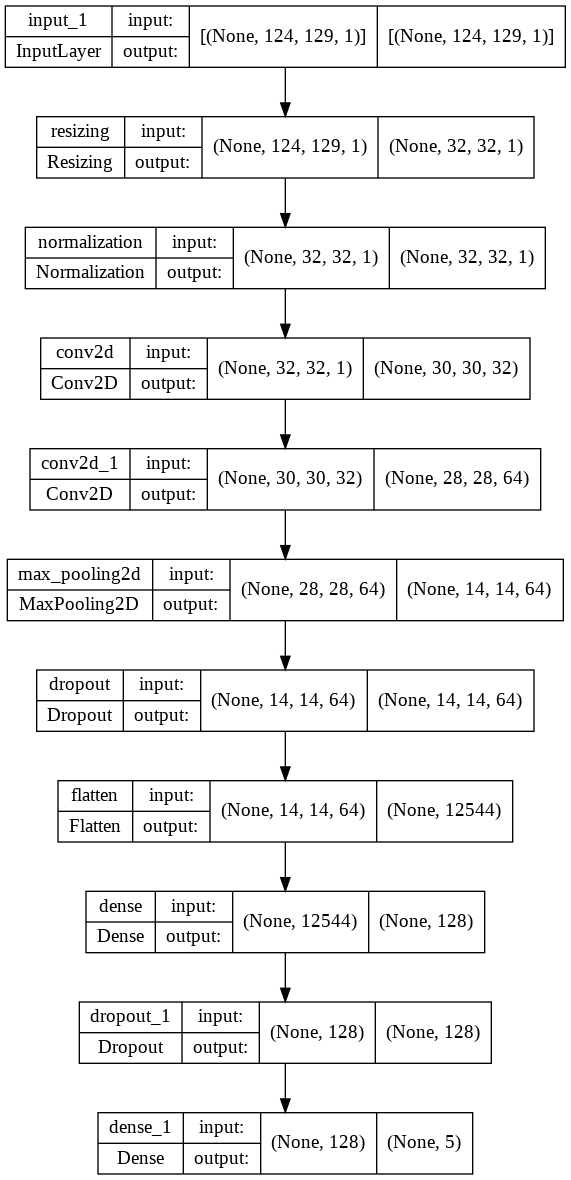

In [45]:
# visualize model architecture
import visualkeras
from PIL import ImageFont
from tensorflow.keras.utils import plot_model

#plot model deep learning
plot_model(model, to_file="model-architecture.png", show_shapes=True)

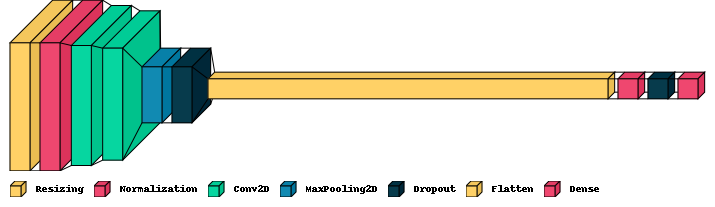

In [46]:
from collections import defaultdict

color_map = defaultdict(dict)

visualkeras.layered_view(model, legend=True, color_map=color_map)

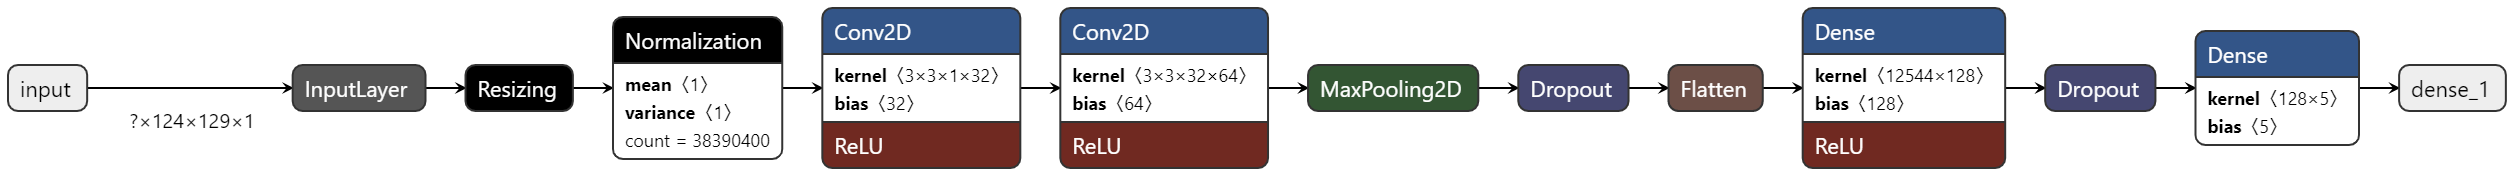

In [47]:
# Save the model to sav
model.save('saved_model.sav')

INFO:tensorflow:Assets written to: saved_model.sav/assets


In [48]:
# Save the model to HDF5
model.save('saved_model.h5')

In [49]:
# convert Model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model.sav') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_audio.tflite', 'wb') as f:
  f.write(tflite_model)

Inference using TensorFlow Lite

In [52]:
!pip install tflite-runtime

In [53]:
from tflite_runtime.interpreter import Interpreter
interpreter = Interpreter('model_audio.tflite')
interpreter.allocate_tensors()

ImportError: ignored

In [ ]:
interpreter.get_input_details()

In [ ]:
interpreter.get_output_details()

the input expected by the model is a tensor of shape (1, 129, 124,1) – the spectrogram which we used to train the model – and the expected output is (1, 5) – the five class alarm.